In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/AI_SpillGuard/dataset.zip" -d /content/dataset


Archive:  /content/drive/MyDrive/AI_SpillGuard/dataset.zip
  inflating: /content/dataset/label_colors.txt  
  inflating: /content/dataset/test/images/Oil (1007).jpg  
  inflating: /content/dataset/test/images/Oil (1019).jpg  
  inflating: /content/dataset/test/images/Oil (1024).jpg  
  inflating: /content/dataset/test/images/Oil (1026).jpg  
  inflating: /content/dataset/test/images/Oil (1037).jpg  
  inflating: /content/dataset/test/images/Oil (1038).jpg  
  inflating: /content/dataset/test/images/Oil (1042).jpg  
  inflating: /content/dataset/test/images/Oil (1044).jpg  
  inflating: /content/dataset/test/images/Oil (1047).jpg  
  inflating: /content/dataset/test/images/Oil (1049).jpg  
  inflating: /content/dataset/test/images/Oil (1050).jpg  
  inflating: /content/dataset/test/images/Oil (1055).jpg  
  inflating: /content/dataset/test/images/Oil (1057).jpg  
  inflating: /content/dataset/test/images/Oil (1061).jpg  
  inflating: /content/dataset/test/images/Oil (1067).jpg  
  infla

In [ ]:
print(os.listdir('/content'))
print(os.listdir('/content/dataset'))
print(os.listdir('/content/dataset/train'))
print(os.listdir('/content/dataset/val'))
print(os.listdir('/content/dataset/test'))


['.config', 'dataset', 'drive', 'sample_data']
['train', 'test', 'val', 'label_colors.txt']
['images', 'masks']
['images', 'masks']
['images', 'masks']


In [ ]:
from glob import glob

def make_pairs(img_dir, mask_dir):
    imgs = sorted(glob(os.path.join(img_dir, "*")))
    masks = sorted(glob(os.path.join(mask_dir, "*")))
    return list(zip(imgs, masks))

train_pairs = make_pairs(
    "/content/dataset/train/images",
    "/content/dataset/train/masks"
)

val_pairs = make_pairs(
    "/content/dataset/val/images",
    "/content/dataset/val/masks"
)

test_pairs = make_pairs(
    "/content/dataset/test/images",
    "/content/dataset/test/masks"
)

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))
print("Test pairs:", len(test_pairs))


Train pairs: 811
Val pairs: 203
Test pairs: 254


In [ ]:
color_to_class_map = {
    0: 0,     # background
    90: 1,    # oil
    174: 2,   # others
    202: 3    # water
}

NUM_CLASSES = 4


In [ ]:
class SegDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, pairs, batch_size, image_size=(256,256),
                 num_classes=NUM_CLASSES, augment=False,
                 color_to_class_map=None):

        self.pairs = pairs
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.augment = augment
        self.color_to_class_map = color_to_class_map
        self.on_epoch_end()

    def __len__(self):
        return len(self.pairs) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.pairs))
        if self.augment:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_idx = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_pairs = [self.pairs[i] for i in batch_idx]

        X = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.int32)

        for i, (img_path, mask_path) in enumerate(batch_pairs):
            img = load_img(img_path, target_size=self.image_size)
            img = img_to_array(img) / 255.0

            mask = load_img(mask_path, target_size=self.image_size, color_mode="grayscale")
            mask = img_to_array(mask).astype(np.int32)

            if self.color_to_class_map:
                for k, v in self.color_to_class_map.items():
                    mask[mask == k] = v

            X[i] = img
            y[i] = mask

        return X, y


In [ ]:
BATCH_SIZE = 4

train_gen = SegDataGenerator(
    train_pairs,
    batch_size=BATCH_SIZE,
    augment=True,
    color_to_class_map=color_to_class_map
)

val_gen = SegDataGenerator(
    val_pairs,
    batch_size=BATCH_SIZE,
    augment=False,
    color_to_class_map=color_to_class_map
)

print("Train batches:", len(train_gen))
print("Val batches:", len(val_gen))


Train batches: 202
Val batches: 50


In [ ]:
X, y = train_gen[0]
print("Image shape:", X.shape)
print("Mask shape:", y.shape)
print("Unique mask values:", np.unique(y))


Image shape: (4, 256, 256, 3)
Mask shape: (4, 256, 256, 1)
Unique mask values: [0 1 2 3]


In [ ]:
model = models.Sequential([
    layers.Input(shape=(256,256,3)),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.UpSampling2D(),
    layers.Conv2D(NUM_CLASSES, 1, activation="softmax")
])


In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 4)    │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,652 (76.77 KB)

 Trainable params: 19,652 (76.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
202/202 ━━━━━━━━━━━━━━━━━━━━ 194s 951ms/step - accuracy: 0.4663 - loss: 1.1138 - val_accuracy: 0.6689 - val_loss: 0.8218
Epoch 2/3
202/202 ━━━━━━━━━━━━━━━━━━━━ 179s 885ms/step - accuracy: 0.6541 - loss: 0.8256 - val_accuracy: 0.7226 - val_loss: 0.7373
Epoch 3/3
202/202 ━━━━━━━━━━━━━━━━━━━━ 206s 902ms/step - accuracy: 0.7040 - loss: 0.7470 - val_accuracy: 0.7248 - val_loss: 0.7170


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


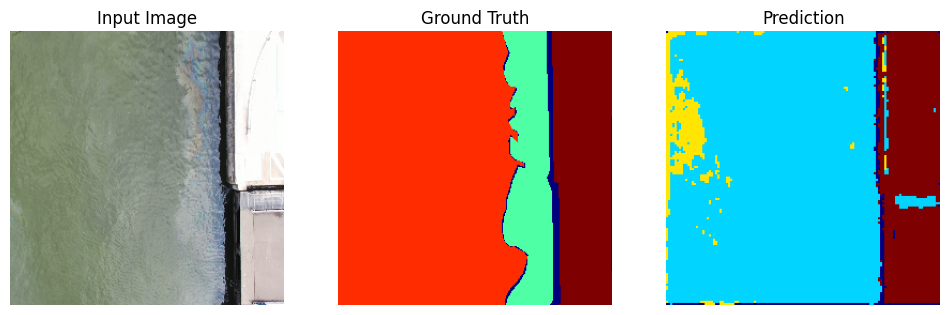

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


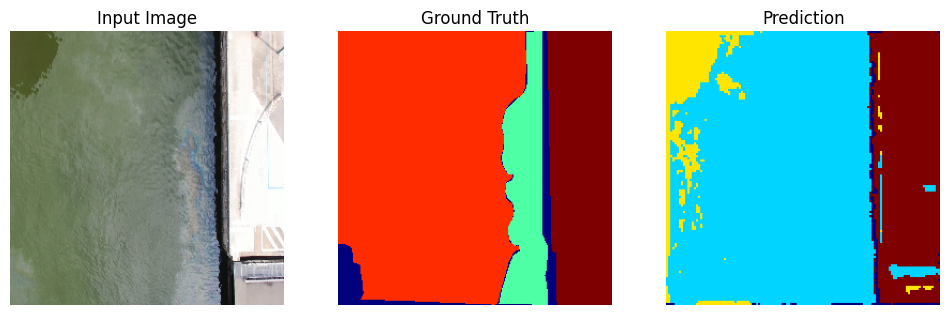

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


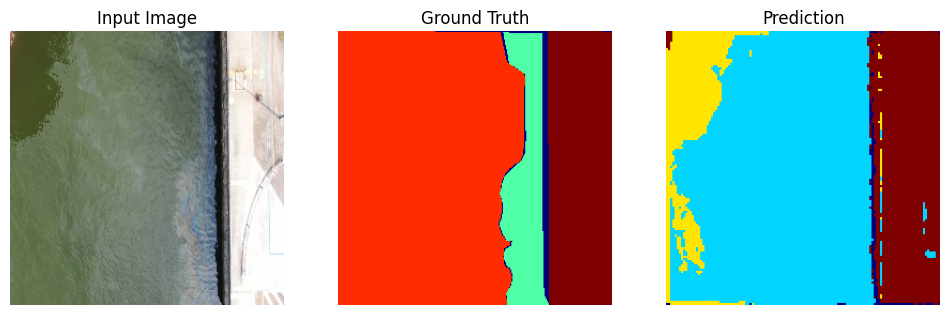

In [ ]:
for i in range(3):
    img_path, mask_path = test_pairs[i]

    img = load_img(img_path, target_size=(256,256))
    img_arr = img_to_array(img)/255.0

    true_mask = load_img(mask_path, target_size=(256,256), color_mode="grayscale")
    true_mask = img_to_array(true_mask)

    pred = model.predict(np.expand_dims(img_arr,0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img_arr)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(true_mask.squeeze(), cmap="jet")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="jet")
    plt.title("Prediction")
    plt.axis("off")

    plt.show()


In [ ]:
model.save("oil_spill_final_model.h5")
print("Model saved in /content")


Model saved in /content


In [ ]:
!cp oil_spill_final_model.h5 /content/drive/MyDrive/
